# Classification Project

## Goal:

- Find out what causes a customer to churn
- Use machine learning to accurately predict if a customer will churn

## Imports

In [1]:
import acquire as a
import prepare as p
import explore as e
import modeling as m

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Acquire

- I acquired the Telco data from the CodeUp MySQL database
- Before anything was done to the data it was 7,043 rows and 24 columns
- Each row represents a different customer's data
- Each column is a feature of that customer

## Prepare

**To prepare the data I did the following:**
- Dropped columns 'payment_type_id', 'internet_service_type_id', and 'contract_type_id'
- Filled in all null values for 'internet_service_type'
- Replaced empty values in 'total_charges' with 0.0
- Removed all empty space infront of numbers in 'total_charges'
- Split that data into train, validate, and test (60/20/20)
- Encoded all columns into 0 or 1, except for
    - 'customer_id'
    - 'total_charges'
    - 'monthly_charges'
- Drops the first of the columns that are encoded

In [2]:
#Acquire
df = a.get_telco_data()
#Prepare
df = p.prep_telco(df)
#Split
train, validate, test = p.split_data(df, 'churn')
#Encode
train_encoded, val_encoded, test_encoded = p.telco_encoded(train, validate, test)

this file exists, reading from csv


**Look At The Data**

In [3]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2865,4083-BFNYK,Female,1,Yes,No,38,Yes,Yes,Yes,Yes,...,No,No,Yes,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic)
4107,5804-LEPIM,Female,1,No,No,2,Yes,No,No,No,...,No,No,No,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check
3453,4895-TMWIR,Male,1,Yes,No,11,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.95,214.75,Yes,Month-to-month,none,Mailed check
923,1342-JPNKI,Male,0,No,No,10,Yes,Yes,No,No,...,No,Yes,No,Yes,86.05,834.10,Yes,Month-to-month,Fiber optic,Bank transfer (automatic)
2370,3397-AVTKU,Male,0,No,No,43,Yes,No,No,Yes,...,No,No,Yes,Yes,60.00,2548.55,No,Two year,DSL,Electronic check


## Explore

### What Percentage of Customers Churn?

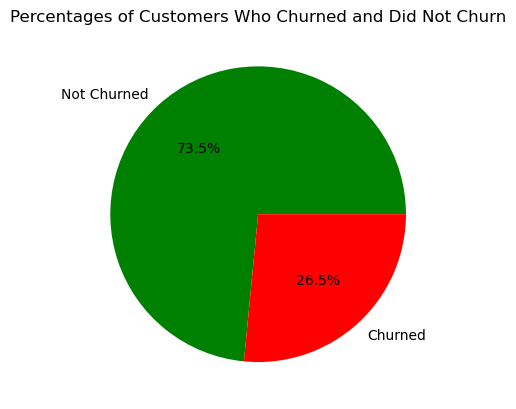

In [4]:
e.get_pie_chart(train_encoded)

- Sightly more than 1/4th of customers churned

### Does Gender Affect If A Customer Churns?

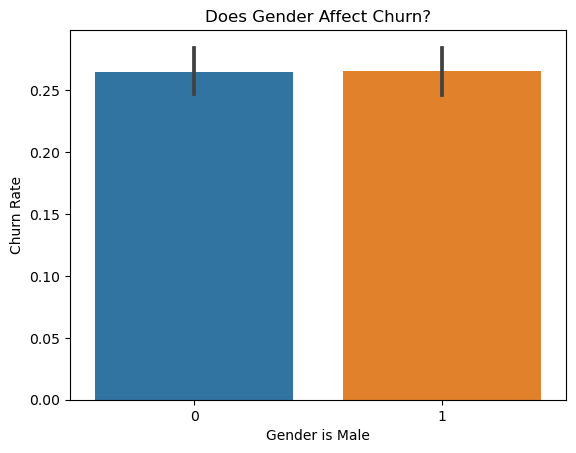

In [5]:
e.get_gender_churn_chart(train_encoded)

- The chart does not show any relation
- I used a chi squared test to determine if there is a relationship


$H_0$: There is NO relationship between Gender and Churn.

$H_a$: There IS relationship between Gender and Churn.

**α**= 0.05

In [6]:
e.chi2_gender_churn(train_encoded)

Fail to reject the null hypothesis
chi^2 = 0.0000
p= 0.9960


- It failed to reject so there is no relationship between gender and churn

### How Does Monthly Charges Affect Churn Over Time?

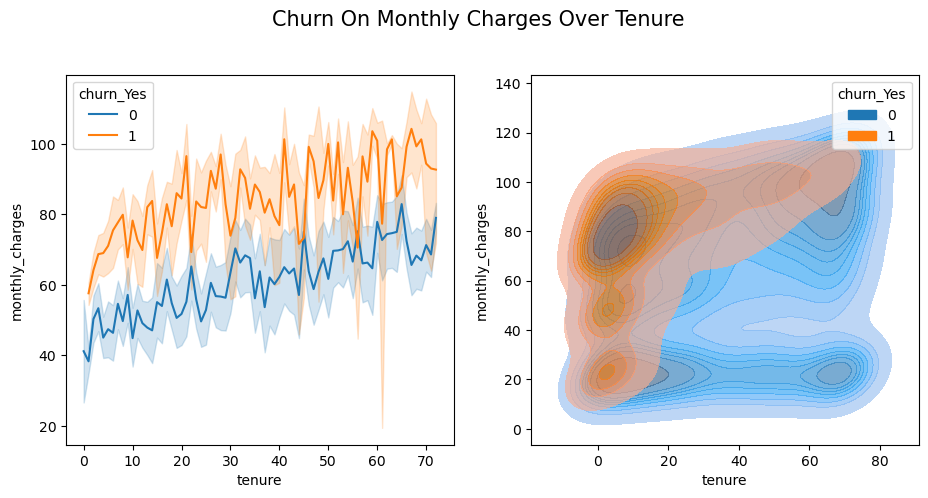

In [7]:
e.get_charge_tenure_chart(train_encoded)

- Customers who churn have an average higher monthly charge than customers who don't churn
- I used a Mann-Whitney U test to determine if there's a relationship

$H_0$: There is NO relationship between Monthly Charges and Churn.

$H_a$: There IS relationship between Monthly Charges and Churn.

**α**= 0.05

In [9]:
e.manwhit_charge_tenure_chart(train_encoded)

Reject the null hypothesis
u_stat = 1343343.0000
p= 0.0000


- We reject the null hypothesis so there is a relationship between monthly charges and churn

### If A Customer Is A Senior Citizen Does That Cause Them To Churn At A Higher Rate?

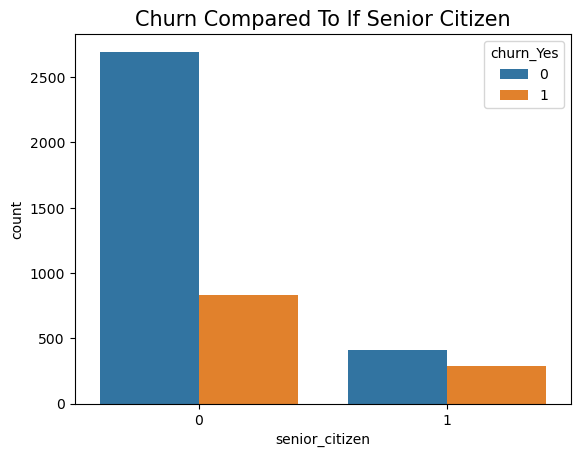

In [10]:
e.senior_citizen_churn_chart(train_encoded)

- The graph shows that senior citizens are more likely to churn
- I used chi squared to determine if there is a relationship

$H_0$: There is NO relationship between Senior Citizens and Churn.

$H_a$: There IS relationship between Senior Citizens and Churn.

**α**= 0.05

In [11]:
e.chi2_senior_citizen(train_encoded)

Reject the null hypothesis
chi^2 = 90.8792
p= 0.0000


- We reject the null hypothesis so there is a relationship

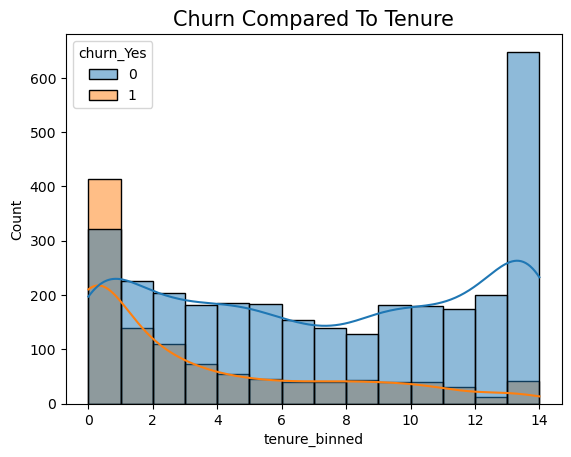

In [12]:
e.tenure_churn_chart(train_encoded)

- Customers who don't churn have a more consistent line for stay
- Customers who churn mostly do so within the first year
- We used a 2 Sample T-test to determine relationship

$H_0$: There is NO relationship between Tenure and Churn.

$H_a$: There IS relationship between Tenure and Churn.

**α**= 0.05

In [13]:
e.ttest_tenure(train_encoded)

Reject the null hypothesis
t_stat = 24.4197
p= 0.0000


- We reject the null hypothesis so there is a relationship

### Exploration Summary

- I found that senior citizen, monthly charges, and tenure all affect the data
- I found that gender does not affect the data
- I will be taking all into my modeling except gender
- I found tenure was one of the biggest factors
    - The longer someone stayed with the company the less likely the would churn
- For monthly charges
    - Customers who churned had a higher mean monthly charge
    - This occurred even as customers who churned lowered over tenure
- The rate for senior citizens churning compared to not churning was higher than customers who weren't senior citizens

## Modeling

- I will be using accuracy to evaluate my models
- The features I will be including in my models are
    - 'monthly_charges'
    - 'senior_citizen'
    - 'tenure'
- The models I use are Decision Tree, Random Forest, and Linear Regression
- My baseline for my model is 73.46%
    - Baseline is decided from taking the mean of the mode which is Churn is No


In [14]:
#preparing the data with X and y
X_train = train_encoded.drop(columns=['churn_Yes', 'customer_id'])
y_train = train_encoded.churn_Yes

X_validate = val_encoded.drop(columns=['churn_Yes', 'customer_id'])
y_validate = val_encoded.churn_Yes

X_test = test_encoded.drop(columns=['churn_Yes', 'customer_id'])
y_test = test_encoded.churn_Yes

### Decision Tree

In [15]:
m.decision_tree_model(X_train, y_train)

Accuracy of Decision Tree classifier on training set: 0.78


### Random Forest

In [16]:
m.random_forest_model(X_train, y_train)

Accuracy of Random Forest classifier on training set: 0.75


### Linear Regression

In [17]:
m.linear_regression_model(X_train, y_train)

Accuracy of Linear Regression classifier on training set: 0.79


- The best model is the Linear Regression because it has 79% accuracy
- All models are above the baseline


- I chose Linear Regression because it had the highest accuracy
- Decision Tree was close with a difference of 1%
- Random Forest was closer to the baseline than it was to Linear Regression

### Test Model

In [18]:
m.linear_regression_model(X_test, y_test)

Accuracy of Linear Regression classifier on training set: 0.79


- From the test model, I can assume this model will have a 79% accuracy in determining customer churn

- The model's test score is above the baseline by almost 4%
- This would be a better model to use than the baseline
- Even though it's not a lot higher it would still yeild the best results in practical use

## Conclusion

### Summary

- Slightly more than 1/4 of customers churn
- Features that affect churning are
    - Monthly Charges, Senior Citizen, and Tenure
- We can infer from the models that monthly charges has the greatest affect on churn
- Gender does not affect churn

### Recommendations

- I would also look at this data based on locations of users, that could also affect churn

### Next Steps

- The next steps would be to add more data to the models to see if it yields a higher accuracy
- Also making more models with stats tests to find more relationships